# Deep Fake Detection. MobileNetV2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as transforms

from torch.optim import lr_scheduler

from torch.utils.data import random_split, DataLoader
from dataset_handlers.feature_dataset import FeatureDataset

import os
from PIL import Image
from matplotlib import pyplot as plt

MobileNet es una red neuronal convolucional desarrollada por Google. Está diseñada para ser ejecutada en dispositivos con recursos limitados, como teléfonos móviles. Es una red neuronal muy eficiente, ya que tiene menos parámetros que otras redes neuronales convolucionales similares, como VGG16 o ResNet50. Esto hace que sea una red neuronal más rápida y que ocupe menos espacio en memoria.

Sus componentes principales son los bloques de convolución separables en profundidad (depthwise separable convolution blocks). Estos bloques están formados por dos capas: una capa de convolución convencional y una capa de convolución 1x1. La primera capa se encarga de realizar la convolución, mientras que la segunda capa se encarga de combinar los resultados de la primera capa. Esto permite reducir el número de parámetros de la red neuronal, ya que la capa de convolución 1x1 tiene menos parámetros que la capa de convolución convencional.

Para más información sobre MobileNet, se puede consultar el siguiente artículo: [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf).

Cargamos el modelo directamente desde Pytorch, ya con los pesos preentrenados en ImageNet.

In [2]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.IMAGENET1K_V1')

Using cache found in C:\Users\carde/.cache\torch\hub\pytorch_vision_v0.6.0


# Fine Tuning

Definimos el modelo, sabiendo que disponemos el dataset de características extraídas de las primeras capas (hasta la 15)

In [3]:
classifier = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 2)
)

In [4]:
model = nn.Sequential(
    model.features[16:],
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    classifier
)

Definimos ahora el número de épocas y el factor de regularización L1, así como el número de folds

In [5]:
num_epochs = 10
l1_factor = 0.0001

k_folds = 5

Utilizamos el optimizador Adam, con una tasa de aprendizaje de 0.0001, y una función de pérdida de entropía cruzada

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Y comenzamos el proceso de entrenamiento

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def accuracy(data_loader, model):
    acc = 0
    for i, (image, label) in enumerate(data_loader, 1):
        image = image.to(device)
        label = label.to(device)

        image = image.reshape(-1, 160, 7, 7)

        output = model(image).reshape(-1, 2)
        acc += (torch.argmax(output, dim=1) == label).sum().item()

    return acc / len(data_loader.dataset)

In [8]:
def train_model(model, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader):
    for epoch in range(num_epochs):
        for i, (image, label) in enumerate(train_loader, 1):
            image = image.to(device)
            label = label.to(device)

            image = image.reshape(-1, 160, 7, 7)

            output = model(image)

            loss = criterion(output, label)

            l1_regularization = torch.tensor(0., requires_grad=False)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)

            l1_regularization.requires_grad_(True)
            loss += l1_factor * l1_regularization

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                acc_training_set.append(accuracy(train_loader, model))
                acc_val_set.append(accuracy(val_loader, model))

                print('Epoch: {}/{}, Batch: {}, Loss: {:.6f}, Acc (train): {:.6f}, Acc (val): {:.6f}'
                      .format(epoch+1, num_epochs, i, loss.item(), acc_training_set[-1], acc_val_set[-1]))

In [12]:
acc_training_set = []
acc_val_set = []

for fold in range(k_folds):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/real_and_fake_mobilenet_data_augmentation_ft/train_{fold}/")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=120, shuffle=True)

    train_model(acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch: 1/10, Batch: 10, Loss: 6.118009, Acc (train): 0.527969, Acc (val): 0.519878
Epoch: 1/10, Batch: 20, Loss: 6.006377, Acc (train): 0.674330, Acc (val): 0.593272
Epoch: 2/10, Batch: 10, Loss: 5.866405, Acc (train): 0.644444, Acc (val): 0.596330
Epoch: 2/10, Batch: 20, Loss: 5.746696, Acc (train): 0.708812, Acc (val): 0.608563
Epoch: 3/10, Batch: 10, Loss: 5.632006, Acc (train): 0.737931, Acc (val): 0.629969
Epoch: 3/10, Batch: 20, Loss: 5.545213, Acc (train): 0.789272, Acc (val): 0.593272
Epoch: 4/10, Batch: 10, Loss: 5.330742, Acc (train): 0.827586, Acc (val): 0.642202
Epoch: 4/10, Batch: 20, Loss: 5.402809, Acc (train): 0.879693, Acc (val): 0.608563
Epoch: 5/10, Batch: 10, Loss: 5.181638, Acc (train): 0.924138, Acc (val): 0.608563
Epoch: 5/10, Batch: 20, Loss: 5.025723, Acc (train): 0.956322, Acc (val): 0.614679
Epoch: 6/10, Batch: 10, Loss: 4.895232, Acc (train): 0.971648, Acc (val): 0.596330
Epoch: 6/10, Batch: 20, Loss: 4.910585, Acc (train): 0.9877

Si comprobamos el accuracy del modelo para los datos de entrenamiendo SIN transformaciones:

In [13]:
for i in range(k_folds):
    test_dataset = FeatureDataset(f"data/real_and_fake_mobilenet_data_augmentation_ft/test_{i}/")
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

    print(f"Accuracy (test) for Fold {i+1}:", accuracy(test_loader))

Accuracy (test) for Fold 1: 0.8215158924205379
Accuracy (test) for Fold 2: 0.8092909535452323
Accuracy (test) for Fold 3: 0.8117359413202934
Accuracy (test) for Fold 4: 0.80440097799511
Accuracy (test) for Fold 5: 0.8117359413202934


# Aumento Masivo de datos

In [28]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

Using cache found in C:\Users\carde/.cache\torch\hub\pytorch_vision_v0.6.0


In [29]:
classifier = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 2)
)

In [30]:
model = nn.Sequential(
    model.features[16:],
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    classifier
)

In [31]:
num_epochs = 10
l1_factor = 0.0001

k_folds = 5

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10

In [12]:
def accuracy(model, data_loader):
    acc = 0
    for i, (image, label) in enumerate(data_loader, 1):
        image = image.to(device)
        label = label.to(device)

        image = image.reshape(-1, 160, 7, 7)

        output = model(image).reshape(-1, 2)
        acc += (torch.argmax(output, dim=1) == label).sum().item()

    return acc / len(data_loader.dataset)

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
acc_training_set = []
acc_val_set = []

for fold in range(k_folds):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_mobilenet_massive_data_augmentation_ft/train_{fold}/")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=3*64, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=3*120, shuffle=True)

    train_model(model, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch: 1/10, Batch: 10, Loss: 6.031771, Acc (train): 0.605548, Acc (val): 0.618622
Epoch: 2/10, Batch: 10, Loss: 5.817175, Acc (train): 0.629145, Acc (val): 0.623724
Epoch: 3/10, Batch: 10, Loss: 5.588640, Acc (train): 0.722577, Acc (val): 0.660714
Epoch: 4/10, Batch: 10, Loss: 5.364243, Acc (train): 0.786990, Acc (val): 0.683673
Epoch: 5/10, Batch: 10, Loss: 5.127033, Acc (train): 0.852360, Acc (val): 0.692602
Epoch: 6/10, Batch: 10, Loss: 4.884398, Acc (train): 0.912628, Acc (val): 0.716837
Epoch: 7/10, Batch: 10, Loss: 4.696449, Acc (train): 0.961097, Acc (val): 0.727041
Epoch: 8/10, Batch: 10, Loss: 4.553024, Acc (train): 0.985013, Acc (val): 0.742347
Epoch: 9/10, Batch: 10, Loss: 4.404867, Acc (train): 0.996811, Acc (val): 0.752551
Epoch: 10/10, Batch: 10, Loss: 4.304027, Acc (train): 0.999043, Acc (val): 0.743622
Training model for Fold:  2
Epoch: 1/10, Batch: 10, Loss: 4.646618, Acc (train): 0.880421, Acc (val): 0.846939
Epoch: 2/10, Batch: 10, Loss: 

Este modelo tomó 27 minutos en ejecutarse en CPU (sin GPU). Si visualizamos los resultados obtenidos:

![img](images/mobile_net_folds.png)

No obstante, hemos cometido el error de posibilitar la filtración de datos, pues al realizar el aumento de datos masivo, es posible que imágenes de validación hayan sido previamente utilizadas para entrenar. Es por lo que, al testear el modelo con el dataset de prueba, obtenemos el siguiente resultado

In [39]:
test_dataset = FeatureDataset(f"data/splitted/test_mobilenet_massive_ft/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

print(f"Accuracy (test):", accuracy(test_loader))

Accuracy (test): 0.6234718826405868


Procedemos así a corregir este error, y simplemente entrenaremos el modelo para el dataset de características aumentado, sin realizar validación cruzada. Únicamente validaremos con los datos de prueba, para decidir cuando parar el entrenamiento y evitar el sobreajuste. Así, volveremos a definir el modelo

In [29]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.IMAGENET1K_V1')

classifier = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 2)
)

model = nn.Sequential(
    model.features[16:],
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    classifier
)

Using cache found in C:\Users\carde/.cache\torch\hub\pytorch_vision_v0.6.0


Y escogeremos el mismo optimizador y función de error que para el modelo al que se le aplicó cross validation.

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [31]:
num_epochs = 20
l1_factor = 0.0001

Y procedemos a entrenar el modelo

In [32]:
acc_training_set = []
acc_val_set = []

dataset = FeatureDataset(f"data/splitted/train_mobilenet_massive_data_augmentation_ft/train_{0}/")
train_loader = DataLoader(dataset=dataset, batch_size=3*64, shuffle=True)

test_dataset = FeatureDataset(f"data/splitted/test_mobilenet_massive_ft/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

train_model(model, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, test_loader)

Epoch: 1/20, Batch: 10, Loss: 6.045247, Acc (train): 0.608163, Acc (val): 0.530562
Epoch: 1/20, Batch: 20, Loss: 5.950596, Acc (train): 0.608163, Acc (val): 0.530562
Epoch: 2/20, Batch: 10, Loss: 5.761797, Acc (train): 0.633163, Acc (val): 0.567237
Epoch: 2/20, Batch: 20, Loss: 5.658105, Acc (train): 0.706888, Acc (val): 0.625917
Epoch: 3/20, Batch: 10, Loss: 5.529825, Acc (train): 0.728827, Acc (val): 0.638142
Epoch: 3/20, Batch: 20, Loss: 5.389197, Acc (train): 0.756378, Acc (val): 0.655257
Epoch: 4/20, Batch: 10, Loss: 5.214550, Acc (train): 0.792857, Acc (val): 0.660147
Epoch: 4/20, Batch: 20, Loss: 5.201595, Acc (train): 0.808929, Acc (val): 0.623472
Epoch: 5/20, Batch: 10, Loss: 4.957716, Acc (train): 0.872194, Acc (val): 0.672372
Epoch: 5/20, Batch: 20, Loss: 4.856603, Acc (train): 0.907653, Acc (val): 0.645477
Epoch: 6/20, Batch: 10, Loss: 4.701108, Acc (train): 0.938520, Acc (val): 0.645477
Epoch: 6/20, Batch: 20, Loss: 4.638561, Acc (train): 0.964031, Acc (val): 0.652812
Epoc

Al visualizar los resultados, nos percatamos de que el modelo no es capaz de ajustarse a los datos sin sobreajuste

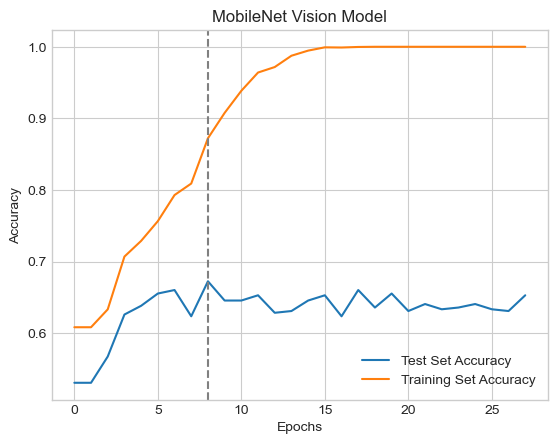